In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import torch

# import helper

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("/home/jovyan/work/TeamAdconsys/Tuomas/modules/")
from rounding import rounding

In [2]:
from timeit import default_timer as timer 
import torch.utils.data as data_utils
from rounding import rounding

def dataloaders(path):
    """
    Function creates dataloaders for neural networks.
    
    EXAMPLE HOW TO DEFINE DATALOADERS:
    ----------------------------------
    train_loader, test_loader, val_loader, large_test_loader = dataloaders('/home/jovyan/work/TeamAdconsys/Tuomas/NN_data')
    
    
    Parameters
    ----------
    
    path :
        - Your path to train, test and validation csv.files.
        - Example: "/home/jovyan/work/TeamAdconsys/Tuomas/NN_data/"
        - Example2: "~/work/TeamAdconsys/proj3-team-adconsys/Datat/csv/"
        

    Returns
    
    -------
    
    Four different dataloaders.
    
    """
    start = timer()
    print("-------------------------------------------------------------")
    print("------------------ Creating Dataloaders ---------------------")
    print("-------------------------------------------------------------\n")
    
    print(f"Reading csv-files from {path}/")
    x_train = pd.read_csv(f"{path}/X_train.csv", header=0)
    y_train = pd.read_csv(f"{path}/y_train.csv", header=0)
    x_test = pd.read_csv(f"{path}/X_test.csv", header=0)
    y_test = pd.read_csv(f"{path}/y_test.csv", header=0)
    
    x_val = pd.read_csv(f"{path}/X_val.csv", header=0)
    y_val = pd.read_csv(f"{path}/y_val.csv", header=0)
    
    # Rounding target values
    y_train = rounding(y_train)
    y_test = rounding(y_test)
    y_val = rounding(y_val)
    
    # Trainloader
    inputs_train = torch.tensor(x_train.values)
    targets_train = torch.tensor(y_train.values)
    
    train = data_utils.TensorDataset(inputs_train, targets_train)
    train_loader = data_utils.DataLoader(train, batch_size=64, shuffle=True)
    
    # Testloader
    inputs_test = torch.tensor(x_test.values)
    targets_test = torch.tensor(y_test.values)
    
    test = data_utils.TensorDataset(inputs_test, targets_test)
    test_loader = data_utils.DataLoader(test, batch_size=64)
    
    # Validationloader
    inputs_val = torch.tensor(x_val.values)
    targets_val = torch.tensor(y_val.values)
    
    val = data_utils.TensorDataset(inputs_val, targets_val)
    val_loader = data_utils.DataLoader(val, batch_size=64)
    
    # Datat yhdistetty (large testloader)
    train_y = pd.read_csv(f"{path}/y_train.csv")
    train = pd.read_csv(f"{path}/X_train.csv")
    train["y"] = train_y
    train.drop_duplicates()
    
    test_y = pd.read_csv(f"{path}/y_test.csv")
    test = pd.read_csv(f"{path}/X_test.csv")
    test["y"] = test_y
    test.drop_duplicates()
    
    val_y = pd.read_csv(f"{path}/y_val.csv")
    val = pd.read_csv(f"{path}/X_val.csv")
    val["y"] = val_y
    val.drop_duplicates()
    
    train = train.append(test)
    train = train.append(val)
    train.drop_duplicates()
    
    train_y = train.drop(columns=['value_1LaskAs'])
    train_y = train_y.drop(columns=['value_MenoM'])
    train_y = train_y.drop(columns=['value_UlkoLampotila'])
    train_y = train_y.drop(columns=['value_LammitysS'])
    train_y = train_y.drop(columns=['value_TuloM'])
    train_y = train_y.drop(columns=['value_TuloilmaLaskettuAs'])
    train_y = train_y.drop(columns=['value_PoistoM'])
    train_y = train_y.drop(columns=['value_PatterinPaluuvesiM'])
    
    train = train.drop(columns=['y'])
    
    large_inputs_test = torch.tensor(train.values)
    large_targets_test = torch.tensor(train_y.values)
    
    large_test = data_utils.TensorDataset(large_inputs_test, large_targets_test)
    large_test_loader = data_utils.DataLoader(large_test, batch_size=64)
    
    print("\nDataloaders:\ntrain_loader:", len(train_loader), "\ntest_loader:", len(test_loader),"\nval_loader:", len(val_loader), "\nlarge_test_loader:", len(large_test_loader))
    
    
    end = timer()
    print("\n\nDone in", round(end-start,2),"seconds.")
    return train_loader, test_loader, val_loader, large_test_loader

    

In [5]:
# Määritetään dataloaderit fuktion avulla
train_loader, test_loader, val_loader, large_test_loader = dataloaders('/home/jovyan/work/TeamAdconsys/Tuomas/NN_data')

-------------------------------------------------------------
------------------ Creating Dataloaders ---------------------
-------------------------------------------------------------

Reading csv-files from /home/jovyan/work/TeamAdconsys/Tuomas/NN_data/

Dataloaders:
train_loader: 5108 
test_loader: 962 
val_loader: 414 
large_test_loader: 6483


Done in 1.46 seconds.


In [7]:
# Määritetään valmiiksi koulutettu verkko
model = torch.load('network.pth')

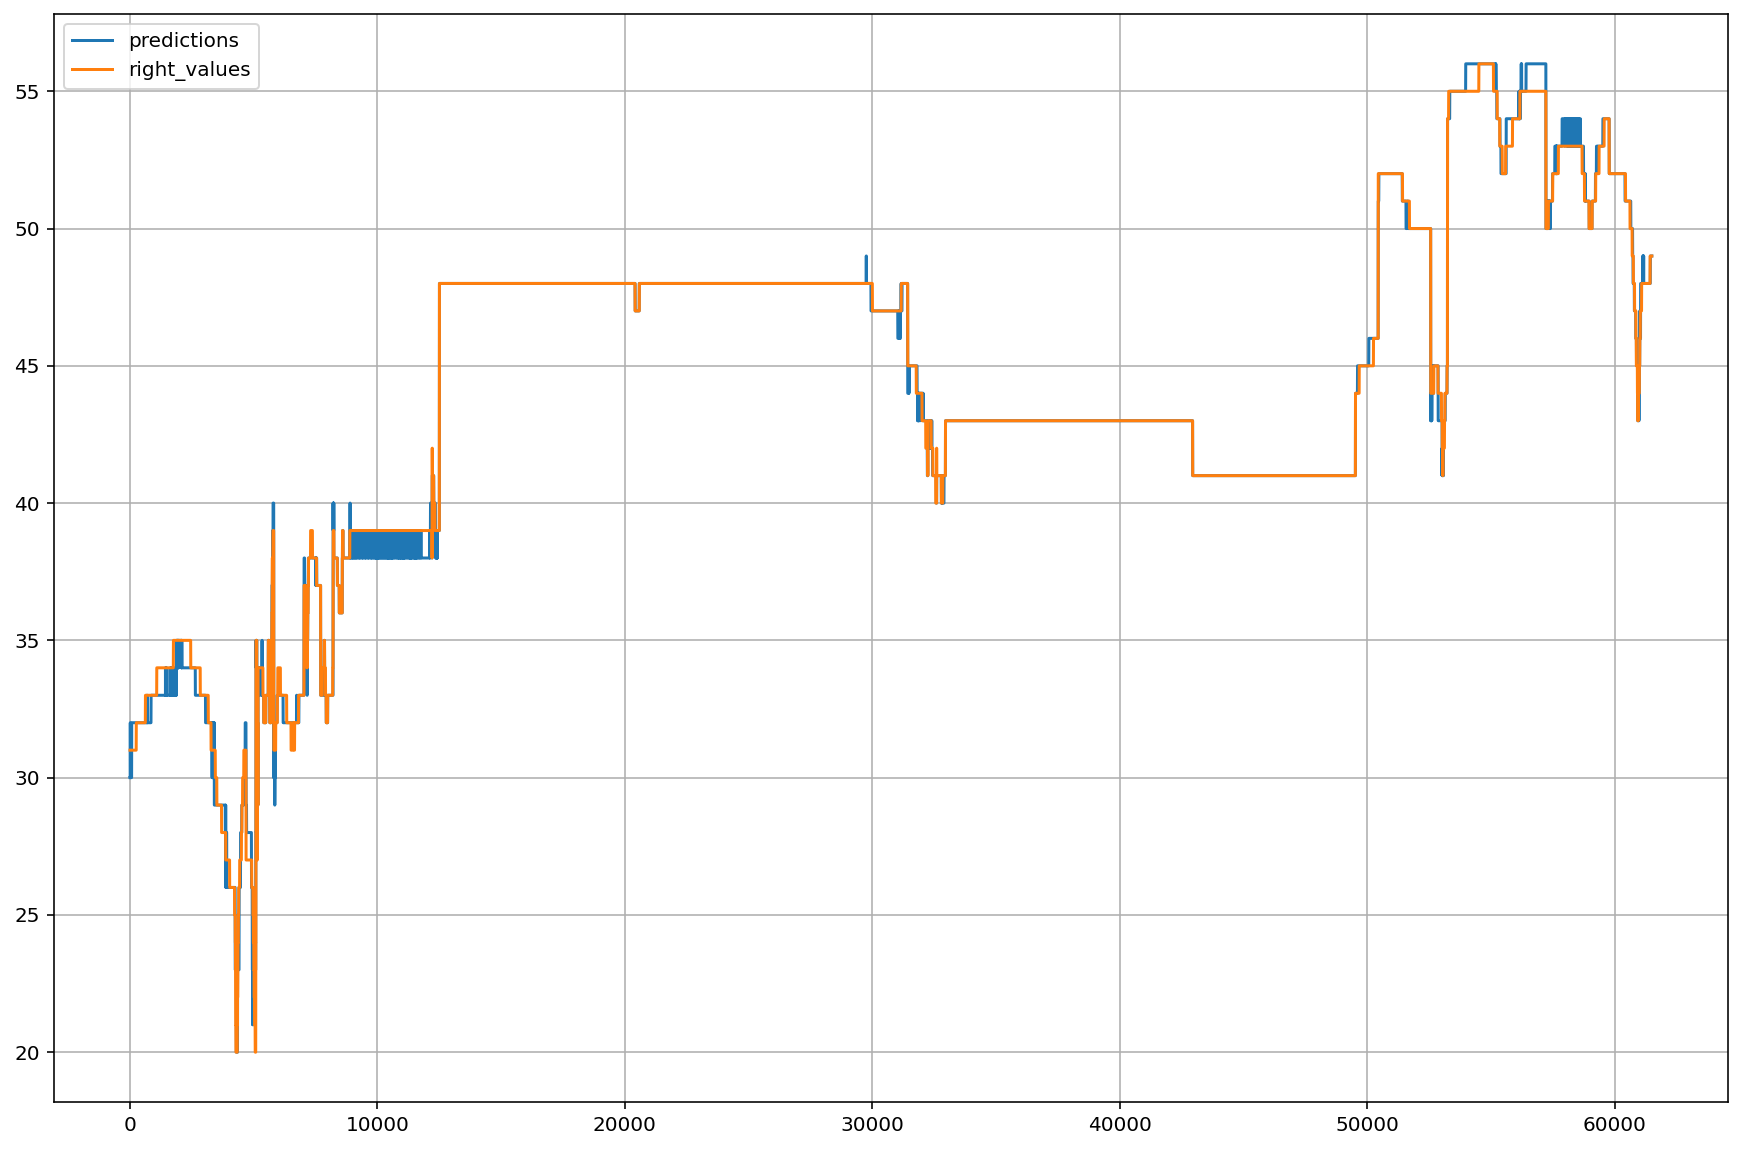

In [8]:
# Plotataan tulokset käyttäen test_loaderin testidataa

predictions = []
right_values = []
values = []
with torch.no_grad():
    for inputs, targets in test_loader:
        
        targets = targets.squeeze_()
        targets = targets.type(torch.LongTensor)
        logps = model(inputs.float())
        
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == targets.view(*top_class.shape)
        
        for index, value in enumerate(equals):
            right_values.append(targets[index].item())
            values.append(inputs[index])
            predictions.append(top_class[index].item())
            
plt.figure(figsize=(15,10))
plt.plot(predictions, label='predictions')
plt.plot(right_values, label='right_values')
plt.legend()
plt.grid()
plt.show()

## Testataan että verkko on oppinut

In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim

In [12]:

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr = 0.03)


# Luodaan listat virheille, joihin aletaan keräämään arvoja
traininglosses = []
testinglosses = []
testaccuracy = []
totalsteps = []
# Valitaan yksi koulutuskierros
# mini-Batchin koko on 64 kuvaa
epochs = 1
# Steps = mini-batch
steps = 0
running_loss = 0
# print_every määirttää minkä verran validointia tehdään
# Vaikuttaa siis loopin kestoon
# Esim. jos print_every olisi 100, niin looppii..
# .. kestäisi huomattavasti vähemmän aikaa
print_every = 15


# 1. looppi pyörittää epokkeja
# 2. pyörittää mini-batcheja
for epoch in range(epochs):
    # tässäkin voisi määrittää stepin nollaksi,
    # mutta se on määritelty jo ylempänä
    # step on siis mini-batchin koko
    
    for inputs, targets in train_loader:
        steps += 1
      
        # Nollataan gradientit
        optimizer.zero_grad()
        
        targets = targets.squeeze()
        targets = targets.type(torch.LongTensor)

        # Ajetaan data mallin läpi
        logps = model(inputs.float())
        # Lasketaan loss-arvo vertaamalla outputtia ja labeleita
        loss = criterion(logps, targets)
        # Lasketaan gradientit jokaiselle muuttujalla takaperin (w')
        # Laskee tässäs tapuksessa ainoastaan classifierille gradientit
        loss.backward()
        
        # Ja päivitetään uudet arvot (w)
        optimizer.step()
        
        # Kokonaisvirhe
        running_loss += loss.item()
        
        # Printataan joka viides kierros
        # Ja ajetaan evaluointi/validiointi kierros
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            # Asetetaan malli evaluointi (arviointi) tilaan
            # Eli ei käytetä dropouttia välissä
            model.eval()
            
            # Gradienttien laskenta pois päältä
            with torch.no_grad():
                # Käytetään testidataa
                for inputs, targets in test_loader:
                    
                    targets = targets.squeeze_()
                    targets = targets.type(torch.LongTensor)

                    logps = model(inputs.float())

                    batch_loss = criterion(logps, targets)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    # Katsotaan top eli todennäköisin luokka
                    top_p, top_class = ps.topk(1, dim=1)

                    equals = top_class == targets.view(*top_class.shape)
                    # Lasketaan paljonko oli ykkösiä eli True-arvoja eli oikeia ennusteita
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Lisätään virheet listoihin 
            traininglosses.append(running_loss/print_every)
            testinglosses.append(test_loss/len(test_loader))
            testaccuracy.append(accuracy/len(test_loader))
            totalsteps.append(steps)
            
            print(
                  f"Epoch {epoch+1}/{epochs}.. "
                  f"Step {steps}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            
            # Nollataan kokonaisvirhe 
            running_loss = 0
            
            # Malli takaisin harjoitustilaan
            model.train()

Epoch 1/1.. Step 15.. Train loss: 0.680.. Test loss: 0.576.. Test accuracy: 0.724
Epoch 1/1.. Step 30.. Train loss: 0.296.. Test loss: 0.459.. Test accuracy: 0.822
Epoch 1/1.. Step 45.. Train loss: 0.209.. Test loss: 0.321.. Test accuracy: 0.879
Epoch 1/1.. Step 60.. Train loss: 0.186.. Test loss: 0.307.. Test accuracy: 0.884


KeyboardInterrupt: 